In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from datetime import timedelta
import holidays

df = pd.read_csv('dailyboardingtotals.csv', parse_dates=['service_date'])
df_sorted = df.sort_values('service_date')
df_sorted.set_index('service_date', inplace=True)

us_holidays = holidays.US()
df_sorted['holiday'] = df_sorted.index.map(lambda x: 1 if x in us_holidays else 0)

In [12]:
model = SARIMAX(df_sorted['total_rides'],
                order=(1, 1, 1),
                seasonal_order=(1, 1, 1, 7), # Weekly seasonality
                exog=df_sorted[['holiday']],
                enforce_stationarity=False, #  Do not enforce stationarity, stationarity is the condition that the time series does not have a trend or seasonal pattern
                enforce_invertibility=False) # Do not enforce invertibility, invertbility is the condition that the roots of the AR polynomial lie outside the unit circle

results = model.fit(disp=False) #disp is set to False to suppress output during fitting, disp is a parameter that controls the display of convergence messages

/Users/abbyzhou/github/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/abbyzhou/github/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


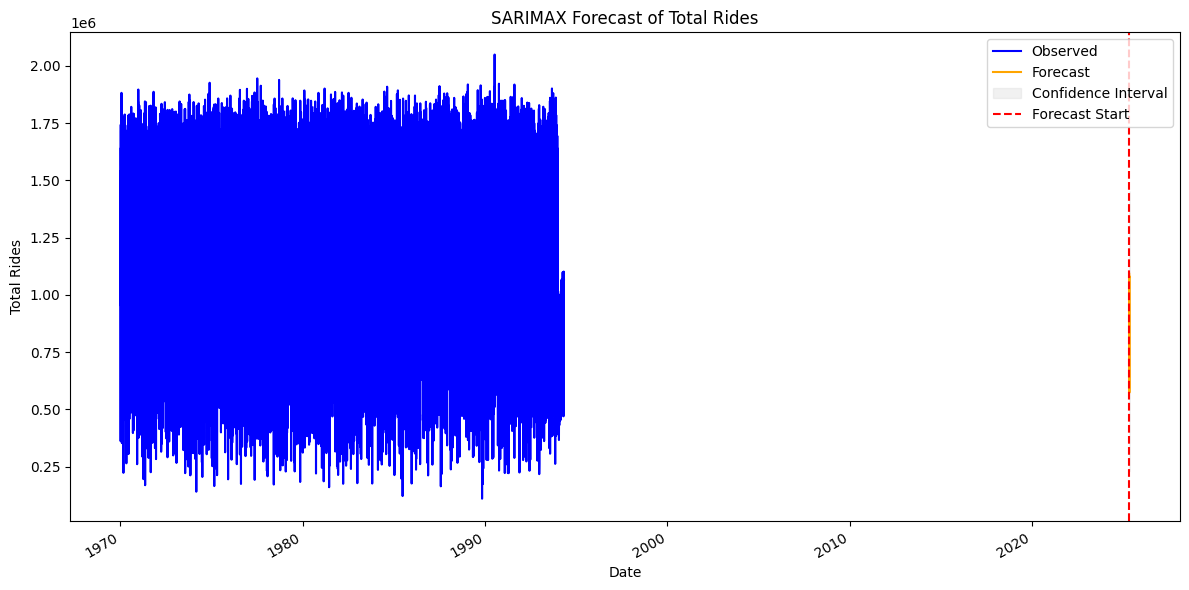

Forecasted values for the next 7 days:
2025-05-01    1091999
2025-05-02    1001296
2025-05-03     762968
2025-05-04     572966
2025-05-05    1010068
2025-05-06    1081449
2025-05-07    1078044
Freq: D, Name: predicted_mean, dtype: int64


In [ ]:
last_date = df_sorted.index[-1]
future_dates = pd.date_range(last_date + timedelta(days=1), periods=7)
future_holidays = future_dates.to_series().apply(lambda x: 1 if x in us_holidays else 0)
future_exog = pd.DataFrame({'holiday': future_holidays}, index=future_dates)

forecast = results.get_forecast(steps=7, exog=future_exog)
predicted = forecast.predicted_mean
conf_int = forecast.conf_int()

plt.figure(figsize=(12, 6))
df['total_rides'].plot(label='Observed', color='blue')
predicted.plot(label='Forecast', color='orange')
plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='lightgray', alpha=0.3, label='Confidence Interval')
plt.axvline(x=last_date, color='red', linestyle='--', label='Forecast Start')
plt.title('SARIMAX Forecast of Total Rides')
plt.xlabel('Date')
plt.ylabel('Total Rides')
plt.legend()
plt.tight_layout()
plt.show()

print("Forecasted values for the next 7 days:")
print(predicted.round().astype(int))

/Users/abbyzhou/github/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/abbyzhou/github/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


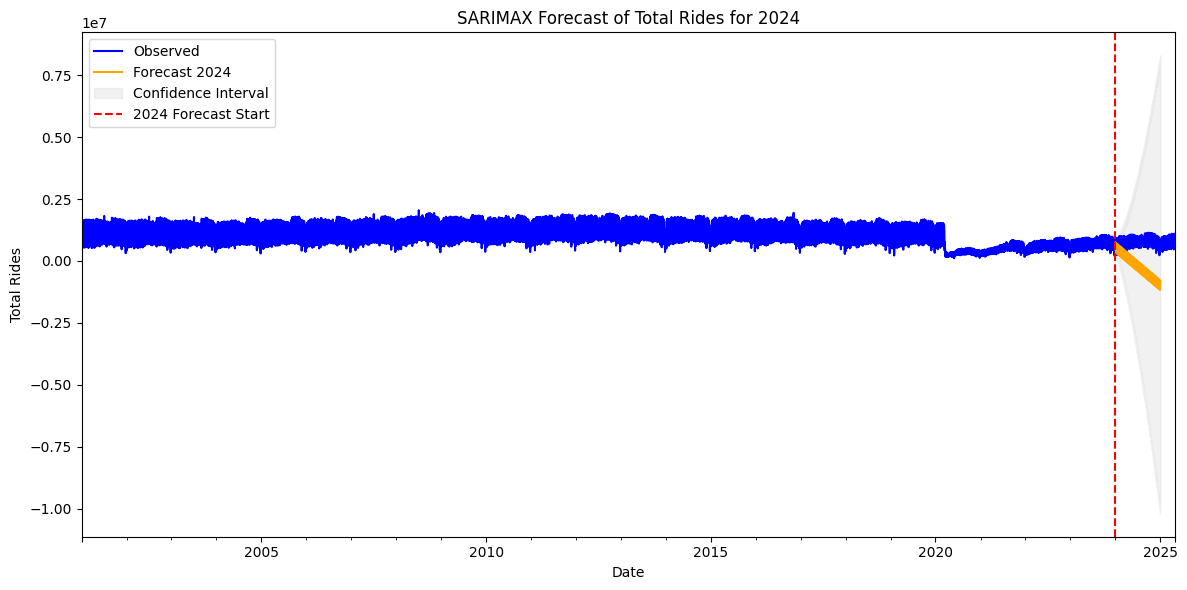

Predicted vs. Observed values for 2024:
            Observed  Predicted
2024-01-01    358731     474762
2024-01-02    695600     735522
2024-01-03    758650     754847
2024-01-04    777714     731643
2024-01-05    726385     678396
...              ...        ...
2024-12-27    640164    -819921
2024-12-28    571490   -1016729
2024-12-29    389660   -1165275
2024-12-30    733119    -885750
2024-12-31    667653    -806416

[366 rows x 2 columns]


In [8]:
# ...existing code...

# 1. Filter data up to the end of 2023 for training
train_df = df_sorted[(df_sorted.index.year > 2020) & (df_sorted.index.year < 2024)]

# 2. Prepare exogenous variable for training
train_exog = train_df[['holiday']]

# 3. Fit the model on data up to 2023
model = SARIMAX(
    train_df['total_rides'],
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 7),
    exog=train_exog,
    enforce_stationarity=False,
    enforce_invertibility=False
)
results = model.fit(disp=False)

# 4. Prepare exogenous variable for 2024
future_df = df_sorted[df_sorted.index.year == 2024]
future_exog = future_df[['holiday']]

# 5. Forecast for all days in 2024
forecast = results.get_forecast(steps=len(future_df), exog=future_exog)
predicted = forecast.predicted_mean
conf_int = forecast.conf_int()

# 6. Plot observed vs. predicted for 2024
plt.figure(figsize=(12, 6))
df_sorted['total_rides'].plot(label='Observed', color='blue')
predicted.plot(label='Forecast 2024', color='orange')
plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='lightgray', alpha=0.3, label='Confidence Interval')
plt.axvline(x=future_df.index[0], color='red', linestyle='--', label='2024 Forecast Start')
plt.title('SARIMAX Forecast of Total Rides for 2024')
plt.xlabel('Date')
plt.ylabel('Total Rides')
plt.legend()
plt.tight_layout()
plt.show()

# 7. Compare predicted vs. actual for 2024
comparison = pd.DataFrame({
    'Observed': future_df['total_rides'],
    'Predicted': predicted.round().astype(int)
})
print("Predicted vs. Observed values for 2024:")
print(comparison)
# ...existing